In [1]:
# Input parameters - change these parameters accordingly

import os

# folder path where the script is stored
BASE_FOLDER_PATH = '/Users/Tushar/Documents/Workspace/autoencoder/'

## We read this csv file to get the list of all the repositories to download.
## This csv file has one columns in this format <user>/<repo_name>
ALL_REPOS_FILE = os.path.join(BASE_FOLDER_PATH, 'java_repos.csv')

## REPO_STORE_ROOT is the folder path where you want to save all the downloaded repositories
REPO_STORE_ROOT = os.path.join(BASE_FOLDER_PATH, 'repos/')
REPOS_TO_DOWNLOAD = 10

SMELLS_ROOT = os.path.join(BASE_FOLDER_PATH, 'smells/')
DJ_path = os.path.join(BASE_FOLDER_PATH, 'DJ/DesigniteJava.jar')
CODESPLIT_PATH = os.path.join(BASE_FOLDER_PATH, 'CodeSplitJava/CodeSplitJava.jar')
CODESPLIT_OUT_PATH = os.path.join(BASE_FOLDER_PATH, 'method_samples')
TRAINING_DATA_FOLDER = os.path.join(BASE_FOLDER_PATH, 'training_data')
TOKENIZER_OUT_FOLDER = os.path.join(BASE_FOLDER_PATH, 'tokenized_samples')
TOKENIZER_PATH = os.path.join(BASE_FOLDER_PATH, 'tokenizer/tokenizer')
OUT_FOLDER = os.path.join(BASE_FOLDER_PATH, 'autoencoder_out')

In [2]:
# Download repositories from GitHub
import os
from subprocess import call

def downloadRepo(repoName):
    fullRepoName = "https://github.com/" + repoName + ".git"
    folderName = repoName.replace("/", "_")
    if not os.path.isdir(os.path.join(REPO_STORE_ROOT, folderName)):
        os.mkdir(folderName)
        try:
            call(["git", "clone", "--depth=1", fullRepoName, folderName])
        except:
            print("Exception occurred!!")
            pass


file = open(ALL_REPOS_FILE, 'rt', errors='ignore')
if not os.path.isdir(REPO_STORE_ROOT):
    os.mkdir(REPO_STORE_ROOT)
os.chdir(REPO_STORE_ROOT)
for line in file.readlines()[:REPOS_TO_DOWNLOAD]:
    repo_name = line.strip('\n')
    if not repo_name == "":
        folder_name = repo_name.replace("/", "_")
        folder_path = os.path.join(REPO_STORE_ROOT, folder_name)
        if not os.path.isdir(folder_path):
            print('downloading ' + folder_name)
            downloadRepo(repo_name)
print('Done.')

downloading lzh9102_qrcode-desktop
downloading airminer_MokaPot
downloading eliasbaixas_bamboo
downloading reelyactive_ble-android-sdk
downloading kicsikrumpli_mdwiki
downloading aastle_fittimer
downloading rmagen_elastic-gremlin
downloading lakshminarayanar_DBLogging_JPA
downloading sohamm17_MapsTraffic
downloading AranyaLi_ToSuccess
Done.


In [3]:
# Detect smells using existing tool to prepare ground truth

import os
import subprocess
from subprocess import Popen, PIPE



# java -jar Designite.jar -i <path of the input source folder> -o <path of the output folder>

def _run_designite_java(folder_name, folder_path, designiteJava_jar_path, smells_results_folder):
    print('analyzing ' + folder_name)
    out_folder = os.path.join(smells_results_folder, folder_name)
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    # logfile = os.path.join(out_folder, "log.txt")
    proc = Popen(["java", "-jar", designiteJava_jar_path, "-i", folder_path, "-o", out_folder])
    proc.wait()


def _build_project(dir, dir_path):
    print("Attempting compilation...")
    os.environ['JAVA_HOME']
    is_compiled = False
    pom_path = os.path.join(dir_path, 'pom.xml')
    if os.path.exists(pom_path):
        print("Found pom.xml")
        os.chdir(dir_path)
#         proc = Popen([r'C:\Program Files (x86)\apache-maven-3.6.2\bin\mvn.cmd', 'clean', 'install', '-DskipTests'])
        proc = Popen([r'mvn', 'clean', 'install', '-DskipTests'])
        proc.wait()
        is_compiled = True

    gradle_path = os.path.join(dir_path, "build.gradle")
    if os.path.exists(gradle_path):
        print("Found build.gradle")
        os.chdir(dir_path)
#         proc = Popen([r'C:\Program Files\Gradle\gradle-5.6.2\bin\gradle.bat', 'compileJava'])
        proc = Popen([r'gradle', 'compileJava'])
        proc.wait()
        is_compiled = True
    if not is_compiled:
        print("Did not compile")

def analyze_repositories(repo_source_folder, smells_results_folder, designiteJava_jar_path):
    for dir in os.listdir(repo_source_folder):
        print("Processing " + dir)
        if os.path.exists(os.path.join(smells_results_folder, dir)):
            print ("\t.. skipping.")
        else:
            _build_project(dir, os.path.join(repo_source_folder, dir))
            _run_designite_java(dir, os.path.join(repo_source_folder, dir), designiteJava_jar_path, smells_results_folder)
    print("Done.")
    

analyze_repositories(repo_source_folder = REPO_STORE_ROOT,
                    smells_results_folder = SMELLS_ROOT,
                    designiteJava_jar_path = DJ_path)

Processing airminer_MokaPot
Attempting compilation...
Found build.gradle
analyzing airminer_MokaPot
Processing sohamm17_MapsTraffic
Attempting compilation...
Found pom.xml
analyzing sohamm17_MapsTraffic
Processing lakshminarayanar_DBLogging_JPA
Attempting compilation...
Found pom.xml
analyzing lakshminarayanar_DBLogging_JPA
Processing rmagen_elastic-gremlin
Attempting compilation...
Found pom.xml
analyzing rmagen_elastic-gremlin
Processing eliasbaixas_bamboo
Attempting compilation...
Did not compile
analyzing eliasbaixas_bamboo
Processing AranyaLi_ToSuccess
Attempting compilation...
Did not compile
analyzing AranyaLi_ToSuccess
Processing lzh9102_qrcode-desktop
Attempting compilation...
Found pom.xml
analyzing lzh9102_qrcode-desktop
Processing reelyactive_ble-android-sdk
Attempting compilation...
Found build.gradle
analyzing reelyactive_ble-android-sdk
Processing aastle_fittimer
Attempting compilation...
Found build.gradle
analyzing aastle_fittimer
Processing kicsikrumpli_mdwiki
Attempt

In [4]:
def _run_code_split(folder_name, folder_path, code_split_result_folder, code_split_exe_path, code_split_mode):
    out_folder = os.path.join(code_split_result_folder, folder_name)
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    subprocess.call(["java", "-jar", code_split_exe_path,
                     "-i", folder_path, "-o", out_folder, "-m", code_split_mode])

def java_code_split(repo_source_folder, code_split_mode, code_split_result_folder, code_split_exe_path):
    assert code_split_mode == "method" or code_split_mode == "class"

    for dir in os.listdir(repo_source_folder):
        print("Processing " + dir)
        if os.path.exists(os.path.join(code_split_result_folder, dir)):
            print ("\t.. skipping.")
        else:
            _run_code_split(dir, os.path.join(repo_source_folder, dir),
                            code_split_result_folder, code_split_exe_path, code_split_mode)
    print("Done.")
    

java_code_split(REPO_STORE_ROOT, 'method', CODESPLIT_OUT_PATH, CODESPLIT_PATH)

Processing airminer_MokaPot
Processing sohamm17_MapsTraffic
Processing lakshminarayanar_DBLogging_JPA
Processing rmagen_elastic-gremlin
Processing eliasbaixas_bamboo
Processing AranyaLi_ToSuccess
Processing lzh9102_qrcode-desktop
Processing reelyactive_ble-android-sdk
Processing aastle_fittimer
Processing kicsikrumpli_mdwiki
Done.


In [5]:
import os
import shutil

def _get_positive_src_file_list(lines, solution, smell_type,
                        code_split_out_folder_method):
    pos_src_file_list = list()

    for line in lines:
        tokens = line.split(",")
        file = os.path.join(os.path.join(os.path.join(
                os.path.join(os.path.join(code_split_out_folder_method, solution), solution),
                                    str(_filter_str(tokens[1]))),
                                str(_filter_str(tokens[2])).replace('<', '').replace('>', '')),
                str(_filter_str(tokens[3])) + ".code")
        if os.path.exists(file):
            if file not in pos_src_file_list:
                pos_src_file_list.append(file)
        else:
            print("Path doesn't exists: " + str(file))
    return pos_src_file_list


def _put_files_in_right_bucket(pos_source_file_list, solution, positive_cases_folder, negative_cases_folder,
                               smell_type, code_split_out_folder_method):
    if not os.path.exists(positive_cases_folder):
        os.makedirs(positive_cases_folder)
    if not os.path.exists(negative_cases_folder):
        os.makedirs(negative_cases_folder)

    total_files_copied = 0
    base_folder_path = os.path.join(code_split_out_folder_method, solution)

    pos_counter = 0
    neg_couter = 0
    for root, dirs, files in os.walk(base_folder_path):
        for file in files:
            src_file_path = os.path.join(root, file)

            namespace = root.replace(code_split_out_folder_method + os.path.sep, "").replace(os.path.sep, "_")

            if _is_present(pos_source_file_list, src_file_path):

                dest_file_path = os.path.join(positive_cases_folder, namespace + str(pos_counter) + file)
                if not os.path.exists(dest_file_path):
                    try:
                        shutil.copyfile(src_file_path, dest_file_path)
                    except:
                        pass
                    total_files_copied += 1
                    pos_counter += 1
                else:
                    print("File already exists: " + str(dest_file_path))  # This should not be the case
            else:
                dest_file_path = os.path.join(negative_cases_folder, namespace + str(neg_couter) + file)
                if not os.path.exists(dest_file_path):
                    try:
                        shutil.copyfile(src_file_path, dest_file_path)
                    except:
                        pass
                    total_files_copied += 1
                    neg_couter += 1
                else:
                    print("File already exists: " + str(dest_file_path))  # This should not be the case
    return total_files_copied


def _is_present(an_list, item):
    if item in an_list:
        return True

    item_upper = item.upper()
    for obj in an_list:
        if obj.upper() == item_upper:
            return True
    return False


def _filter_str(token):
    #line = token.decode('utf-8', 'ignore').encode("utf-8")
    line = bytes(token, 'utf-8').decode('utf-8', 'ignore')
    return line


def _scan_solution(solution, positive_cases_folder, negative_cases_folder,
                   smell_name_str, smell_type, smells_results_folder,
                    code_split_out_folder_method):
    print("Processing solution: " + solution)
    solution_folder = os.path.join(code_split_out_folder_method, solution)

    if os.path.exists(solution_folder):
        total_file_count = sum([len(files) for r, d, files in os.walk(solution_folder)])
        if total_file_count == 0:
            return
    else:
        return

    pos_source_file_list = list()
    for root, dirs, files in os.walk(os.path.join(smells_results_folder, solution)):
        for file in files:
            if smell_type == "Design":
                if not file.endswith("DesignSmells.csv"):
                    continue
            else:
                if not file.endswith("ImplementationSmells.csv"):
                    continue
            print("Processing file: " + os.path.join(root, file))
            lines = []
            with open(os.path.join(root, file), encoding="utf8", errors='ignore') as fp:
                for line in fp:
                    if smell_name_str in line:
                        lines.append(line)

            pos_source_files = _get_positive_src_file_list(lines, solution, smell_type,
                           code_split_out_folder_method)
            pos_source_file_list.extend(pos_source_files)
    total_copied_files = _put_files_in_right_bucket(pos_source_file_list, solution, positive_cases_folder, negative_cases_folder,
                               smell_type, code_split_out_folder_method)
    # Sanity check
    assert (total_file_count == total_copied_files)


def generate_data(smells_results_folder, code_split_out_folder_method, learning_data_folder_path):
    SMELL_NAME_LIST = ["ComplexMethod"]
    SMELL_NAME_STR_LIST = ["Complex Method"]
    SMELL_TYPE_LIST = ["Impl"]

    if not os.path.exists(learning_data_folder_path):
        os.makedirs(learning_data_folder_path)
    for smell in range(len(SMELL_NAME_LIST)):
        print("Generating samples for {0} smell...".format(SMELL_NAME_LIST[smell]))
        positive_cases_folder = os.path.join(learning_data_folder_path, SMELL_NAME_LIST[smell], "Positive")
        negative_cases_folder = os.path.join(learning_data_folder_path, SMELL_NAME_LIST[smell], "Negative")

        for solution in os.listdir(smells_results_folder):
            _scan_solution(solution, positive_cases_folder, negative_cases_folder,
                           SMELL_NAME_STR_LIST[smell], SMELL_TYPE_LIST[smell], smells_results_folder,
                           code_split_out_folder_method)
    print('Done.')

            
generate_data(SMELLS_ROOT, CODESPLIT_OUT_PATH, TRAINING_DATA_FOLDER)

Generating samples for ComplexMethod smell...
Processing solution: airminer_MokaPot
Processing file: /Users/Tushar/Documents/Workspace/autoencoder/smells/airminer_MokaPot/ImplementationSmells.csv
Processing solution: sohamm17_MapsTraffic
Processing file: /Users/Tushar/Documents/Workspace/autoencoder/smells/sohamm17_MapsTraffic/ImplementationSmells.csv
Processing solution: lakshminarayanar_DBLogging_JPA
Processing file: /Users/Tushar/Documents/Workspace/autoencoder/smells/lakshminarayanar_DBLogging_JPA/ImplementationSmells.csv
Processing solution: rmagen_elastic-gremlin
Processing file: /Users/Tushar/Documents/Workspace/autoencoder/smells/rmagen_elastic-gremlin/ImplementationSmells.csv
Processing solution: eliasbaixas_bamboo
Processing file: /Users/Tushar/Documents/Workspace/autoencoder/smells/eliasbaixas_bamboo/ImplementationSmells.csv
Processing solution: AranyaLi_ToSuccess
Processing file: /Users/Tushar/Documents/Workspace/autoencoder/smells/AranyaLi_ToSuccess/ImplementationSmells.cs

In [6]:
import os
import subprocess
import shutil


# To figure out whether a file contains multiple definitions of a method,
# we tokenize the file using "method" config and checks whether it contains multiple lines.
def _is_contain_overloaded_methods(input_file, tokenizer_path, tokenizer_language):
    temp_file = "temp.tok"
    if os.path.exists(temp_file):
        os.remove(temp_file)
    with open(temp_file, "w", errors='ignore') as tok_out_file:
        process = subprocess.Popen([tokenizer_path, "-l", tokenizer_language, "-o", "method", input_file],
                                   bufsize=10240000, stdout=tok_out_file)
        process.wait()

    with open(temp_file, "r", errors='ignore') as in_f:
        tok_text = in_f.read()
    length = 0
    for line in tok_text.lstrip("b'").rstrip("'\\n").split("\n"):
        if len(line) > 0:
            length += 1
    if(length > 1):
        return True
    return False


def _run_tokenizer(folder_path, out_folder, tokenizer_path, tokenizer_language, tokenizer_level):
    if os.path.exists(out_folder):
        shutil.rmtree(out_folder)
    os.makedirs(out_folder)
    file_counter = 1
    out_file = os.path.join(out_folder, "tokenized" + str(file_counter) + ".tok")
    for file in os.listdir(folder_path):
        input_file = os.path.abspath(os.path.join(folder_path, file))
        try:
            print("\t\tprocessing " + file)
        except:
            pass
        in_file = os.path.abspath(os.path.join(out_folder, "temp.tok"))
        if os.path.exists(in_file):
            os.remove(in_file)
        with open(in_file, "w", errors='ignore') as tok_out_file:
            exe_path = os.path.abspath(tokenizer_path)
            subprocess.run([exe_path, "-l", tokenizer_language, "-o",
                                        tokenizer_level, input_file], stdout=tok_out_file)
            # process.wait()

        with open(out_file, "a", errors='ignore') as f:
            with open(in_file, "r", errors='ignore') as in_f:
                tok_text = in_f.read()
            f.write(tok_text.lstrip("b'").rstrip("'\\n"))
        os.remove(in_file)
        if os.path.getsize(out_file) > 52428800: #50 mb
            file_counter += 1
            out_file = os.path.join(out_folder, "tokenized" + str(file_counter) + ".tok")


def _get_max_length(tok_text):
    max_length = 0
    for line in tok_text.split('\n'):
        tokens = line.split('\t')
        if len(tokens) > max_length:
            max_length = len(tokens)
    return max_length


# tokenizer_language should be either "CSharp" or "Java"
def tokenize(tokenizer_language, tokenizer_input_base_path, tokenizer_out_base_path, tokenizer_exe_path):
    if not os.path.exists(tokenizer_out_base_path):
        os.makedirs(tokenizer_out_base_path)

    list = ["ComplexMethod"]
    assert tokenizer_language == "CSharp" or tokenizer_language == "Java"

    for dir in list:
        # default dimension is 1, so tokenizer level would be method
        tokenizer_level = "method"
        dim_str = "1d"
        print("Processing {0} smell for dimension {1}".format(dir, dim_str))
        cur_base_folder = os.path.join(tokenizer_input_base_path, dir)

        print("\t processing positive cases...")
        cur_folder = os.path.join(cur_base_folder, "Positive")
        out_folder = os.path.join(os.path.join(os.path.join(tokenizer_out_base_path,
                                                            dir), dim_str), "Positive")
        _run_tokenizer(cur_folder, out_folder, tokenizer_exe_path, tokenizer_language, tokenizer_level)

        print("\t processing negative training cases...")
        cur_folder = os.path.join(cur_base_folder, "Negative")
        out_folder = os.path.join(os.path.join(os.path.join(tokenizer_out_base_path,
                                                            dir), dim_str), "Negative")
        _run_tokenizer(cur_folder, out_folder, tokenizer_exe_path, tokenizer_language, tokenizer_level)
    print("Tokenizing done.")

    
tokenize("Java", TRAINING_DATA_FOLDER, TOKENIZER_OUT_FOLDER, TOKENIZER_PATH)

Processing ComplexMethod smell for dimension 1d
	 processing positive cases...
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_ReturnToClient82run.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_UdpCC41handle_readable.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_Node27fill_holes_have_children.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vivaldi_Vivaldi10handleEvent.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_Dht90compileResponse.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_FetchNodeInfoThread3interpret_tokens.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_OldStorageManager125handle_put_req.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_OldStorageManager124handle_get_by_guid_cont.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.openhash.fileshare_FileShare35main.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_b

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_GatewayClient98handleEvent.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht.fssim_FairRateAlgorithm79process_pending_puts.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_GraphUtils31dijkstra.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_ClientThread81run.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_StorageManager110compareTo.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_UdpCC42handle_ack.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht.fssim_VirtualTimeAlgorithm74process_pending_puts.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.util_MultipleByteBufferInputStream130read_skip_impl.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_DataManager25handle_leaf_set_changed.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_MerkleTree29fill_holes_have_children.code
	

		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.service_ConfigurationPropertiesService347getLogLevelForMessageSaving.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_OldStorageManager1797handle_get_by_guid_req.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.security.users.service_UserToAccessRightsServiceImpl377delete.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_StorageManager1668GetByGuidResp.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_bamboo_get_result1419xdrEncode.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_ElasticFeatures154supportsStringArrayValues.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_MerkleTree461set_leaves_below.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_AuditDetail199setAuditMas

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vivaldi_LocateNodeResp290getLocatedCoordinate.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_Gateway1577init.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_CachingNetworkModel587compute_route_info.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_OldStorageManager1775handle_get_by_key_req.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_SearchBean227getTransactionStartDateTime.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_XmlRpcGetHandler1310get.code
		processing airminer_MokaPot_airminer_MokaPot_airminer.mokapot_MokaPotServer78getRecipesFor.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.queryhandler.virtualvertex_VirtualVertexHandler28checkBulk.code
		processing aastle_fittimer_aastle_fittimer_com.aastle.fittimer_DatabaseHelper37close.code
		processing eliasb

		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_UserToAccessRights73setId.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.openhash.i3_LookupService915send_i3_range.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_NioInputBuffer733nextLong.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_Router1177remove_from_rt.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_BluetoothCrashResolver282onProgressUpdate.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_AuditMaster124getCustomInt2.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_AuditMaster134setUpdatedDateTime.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_PriorityQueue777size.code
		processing lakshminarayanar_DBLogging_JPA_lakshminaraya

		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.service_BleService2stopScan.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.service_AuditMasterService337getResultByUniqueProcessId.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_Network800serialize_size.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble.util_BluetoothInterface61getMacAddress.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_SystemAuditTrail240setActivity.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_FetchNodeInfoThread14outstanding.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_PutOrRemoveAck377clone.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_ASyncCoreImpl708cancelTimer.code
		processing airminer_MokaPot_airminer_MokaPot_airmi

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_RoutingTableResp973toString.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_LocationCache1061remove_node.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.www_ConnState1985ConnState.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_OldStorageManager1791RemoveMonitor.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_RouterCallbackInterface1097route_deliver.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.queryhandler.elasticsearch.vertexdoc_DocVertexHandler227vertices.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_GatewayClient1503try_next_gateway.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_ScanResult193toString.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_PutGetTest1483equals.code
		processing rmagen_elastic-greml

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_Vis105fit_in_window.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.transport_RecvMsgCb209recv_msg_cb.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.fst_TestClient626run.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_ScanResultParser231getSystemIdBytes.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_Dht1368handle_put_resp_msg.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_PingMsg1074clone.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_Dump1703init.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_IonTree1340main.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_SearchBean228getMessageFormat.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_IonTree1339shift_time.code
		processing laks

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_RouterCallbackInterface1088RouterCallbackInterface.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui_MainWindow98accept.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_StageWrapper828destroy.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vivaldi_VivaldiRequestVC283VivaldiRequestVC.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_Role92getId.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_AuditMaster183setJournalSeq.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_Rpc884SendToken.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_Node439leaves_below.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_GatewayClient1488init.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_DustDevil838DustDevil.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.security.users.service_UsersServiceImpl387delete.code
		processing airminer_MokaPot_airminer_MokaPot_airminer.mokapot_MokaPotServer64getBanList.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui.generator_PhoneNumberGenerator40getPanel.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin_ElasticGraphGraphProvider298getImplementations.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_AddMonitor1740AddMonitor.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_GatewayTest1508ClientThread.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blescanner_BleScanFragment52onCreateView.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.service_Aud

		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_LBluetoothLeScannerCompat93run.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_Router1205handle_leaf_set_changed.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_BambooNode30show_guid.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_gateway_protClient1292BAMBOO_DHT_PROC_GET_2.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.queryhandler.elasticsearch.stardoc_InnerEdge302InnerEdge.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_SimulatorLogAppender595SimulatorLogAppender.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.repository_SystemAuditTrailRecordRepository40findByisDeleted.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_BaseEdge167createProperty.code
		processing lakshminar

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.api_BambooRouteInit247BambooRouteInit.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_ElasticVariableFeatures78supportsDoubleValues.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.advertise_DummyBleAdvertiser76Worker.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.service_AuditMasterServiceImpl355decreaseOneDayFromDate.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_ElasticVertexPropertyFeatures224supportsUserSuppliedIds.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_CoordResp1001CoordResp.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui_ScreenCaptureWindow156mousePressed.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht.fssim_MyPutInfo1248MyPutInfo.code
		processing eliasbaix

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_DataManager339handle_fetch_merkle_tree_node_reject.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_Simulator546NodeCleanupCb.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.www_WebAppender2014setErrorHandler.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_ConfigurationProperties206getSaveXslTransformer.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_BluetoothCrashResolver288doInBackground.code
		processing airminer_MokaPot_airminer_MokaPot_airminer.mokapot_MokaPotServer73getTicksPerMonsterSpawns.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_Network807timer_cb.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_PutGetTest1475GetInfo.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_DiskSizeMsg1559clone.code
		processing 

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_GatewayClient1494set_client_library.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.application_ReelyAwareApplicationCallback306bindBleService.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_Dht1400slop_space_avail.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.security.users.service_UsersService412create.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_ElasticFeatures130supportsCustomIds.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_Connection760can_send_either.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.advertise_DummyBleAdvertiser79getJsonBase.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht.fssim_Test11218main.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bambo

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.openhash.multicast_JoinCb138timer_cb.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.service_LocalBinder19getService.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_MerkleTreeTest402draw_tree.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_Router1174weighted_random_rt_level.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_GatewayClient1504get.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_MyIterator1009MyIterator.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_PutInfo1518compareTo.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_BluetoothCrashResolver291isRecoveryInProgress.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_bamboo_put_args1358xdrDecode.code
		processing reelyactive_ble-android-sdk_reelyact

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.openhash.redir_RedirClient944bytes2bi.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.service_BleService14onScanCycleCompleted.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_DustDevil844acore_instance.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.service_BleService9getMatchingRecentResults.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_BetterPutGetTest1453randomIndex.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vivaldi_Vivaldi302handleStatusAlarm.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.util_StreamOutputBuffer1951error.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_RecoverFatal1753secondaryKeyCreate.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_Dht1396PutReq.code
		processing reelyactive_ble-android-sdk_reelyacti

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vivaldi_FiveDVC284getDimensions.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_ElasticEdgeFeatures186willAllowId.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.openhash.multicast_TcpMsgChannel156TcpMsgChannel.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.xml.utility_EbcdicToAsciiConvertUtility65resizeArray.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_RouteMsg978toString.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_Users260getLastModifiedBy.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_ScanResult196getScanRecord.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_StorageManager1645handle_iterate_by_guid_cont.code
		processing eliasbaixas_bamboo_eliasbaixas

		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_AccessLog277setLevel.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_BluetoothUuid235isAudioSource.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_ElasticFeatures142supportsBooleanArrayValues.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_ElasticVariableFeatures74supportsByteArrayValues.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_SystemAuditTrail252getActorUserId.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_BluetoothCrashResolver287getLastBluetoothCrashDetectionTime.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.queryhandler_Predicates2equals.code
		processing rmagen_elastic

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.util_XdrClone1937xdr_clone.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_Role85getRole.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_IterGetState1350IterGetState.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_DataManager363handle_fhs.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_DustDevil843create_network_stage.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blescanner_BleScanFragment47BleScanFragment.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.advertise_BleAdvertiserProvider70createInstance.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_FetchDataReq375serialize.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_Gateway1573get_common.code
		processing eliasbaixas_bamboo_eliasb

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht.fssim_PutInfo1262PutInfo.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.security.users.service_UserToAccessRightsServiceImpl373findByUserId.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.queryhandler.elasticsearch.vertexdoc_DocVertexHandler228vertex.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht.fssim_ContinuousAlgorithm1236commitment.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.util_Certificate1854check.code
		processing lzh9102_qrcode-desktop0DesigniteLog20032021_2013.txt
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.api_BambooRoutingTableChanged249BambooRoutingTableChanged.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_RoutingTable1041matching_digits.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_Router1159set_initialized.code
		processing la

		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_BluetoothLeScannerCompatProvider107areHardwareFeaturesSupported.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_Router1192use_as_periodic_ping.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_DustDevilSink864enqueue_commit.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_Dht1385timer_cb.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_GraphUtils499add_edge.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_Role97setDescription.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.util_Function41849run.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_BambooNode32undraw_leaf_set.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_UdpCC684can_send_ack.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_

		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui.generator_UrlGenerator81getText.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_LoadNodeCb489load_next_node.code
		processing aastle_fittimer0DesigniteLog20032021_2013.txt
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_DuplicateTypeException737toString.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui.generator_ContactGenerator44setNameField.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_ElasticGraph193vertices.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.api_BambooRouteUpcall239BambooRouteUpcall.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_FetchNodeInfoThread12check_bounds.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.softscribe_Scribe1632init.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_(default package)_DelayedHelloWorld1821run.code
		processing lz

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_NeighborInfo1107hashCode.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blescanner_ReelyAwareScanActivity27onCreate.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_BluetoothCrashResolver284finishRecovery.code
		processing airminer_MokaPot_airminer_MokaPot_airminer.mokapot_MokaPotServer18getWorld.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_Vis104return_new_node.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.user.accesslog.logging_AccessLogServiceImpl315findAll.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.util_XdrByteBufferEncodingStream1973endEncoding.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_AuditMaster152getCustomString3.code
		processing rmagen_elastic-gremlin_rm

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_IonTree1334remove_range.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_BluetoothLeScannerCompat213getMaxPriorityScanMode.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_StorageManager1695handle_iterate_by_guid_req.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_Load1741run.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_ElasticFeatures151supportsUniformListValues.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_Network517run.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.security.users.service_AccessRightsService404delete.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui_RectArea123getH.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_ElasticFeatures1

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.util_StandardStage1905dispatch.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.queryhandler.elasticsearch.stardoc_InnerEdge304innerAddProperty.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_UdpCC687set_mac_key.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.softscribe_Scribe1636printChildTable.code
		processing sohamm17_MapsTraffic_sohamm17_MapsTraffic_(default package)_Traffic8getAvenueOrStreetNumber.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_PutGetTest1480PutInfo.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.repository_RoleRepository12findAllInSet.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.elastic_ConfigurationTests280startUp.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_PeriodicPingCB1078failure.code
		processing el

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_LeafSetLatencies21nid2url.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_ElasticFeatures137supportsMultiProperties.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_AccessLog282setActorUserId.code
		processing airminer_MokaPot_airminer_MokaPot_airminer.mokapot_MokaPotServer34getPlayerExact.code
		processing aastle_fittimer_aastle_fittimer_com.aastle.fittimer_DatabaseHelper32getColumnsArray.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.util_Function31850run.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_OldStorageManager1789handle_get_by_time_cont.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.service_ConfigurationPropertiesServiceImpl341updateNewXSLTFile.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_Vis84find_nod

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_ASyncCore745async_main.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.util_LruMap1896LruMap.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_StorageManagerTest1709StorageManagerTest.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_TputTest788recv.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_RouterCallbackInterface1092handle_app_reg_resp.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_SrcDst558equals.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.queryhandler.elasticsearch.helpers_LazyGetter253register.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui.generator_ContactGenerator49getMemoField.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_AccessRights107setId.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-d

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_Router1167notify_reverse_routing_table_changed.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_PriorityQueue779isEmpty.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_RoutingTableReq1124clone.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_Vis62redraw.code
		processing airminer_MokaPot_airminer_MokaPot_airminer.mokapot_MokaPot95helloWorld.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_bamboo_put_arguments1323xdrEncode.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_SimulatorClockCB492date.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_Network804deserialize.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.openhash.multicast_MulticastClient183bytes2addr.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.security.users.service_AccessRightsServiceIm

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_NioInputBuffer728nextShort.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_BluetoothCrashResolver281processStateChange.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_GatewayClient1505put_done_cb.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.queryhandler.elasticsearch.helpers_ElasticMutations267getRevision.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui.generator_ContactGenerator59getPanel.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo_SimpleStage928serialize.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_AuditMaster172setCreatedDateTime.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht.fssim_EventCb1274cb.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.struc

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_Rpc887sendResponse.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_gateway_protClient1294BAMBOO_DHT_PROC_PUT_3.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_GatewayClient1490remove.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui_MainWindow110MainWindow.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_BetterPutGetTest1438compareTo.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_TputTest790timer_cb.code
		processing airminer_MokaPot_airminer_MokaPot_airminer.mokapot_MokaPotServer37getAnimalSpawnLimit.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_IterGetResp1474serialize.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui_MainWindow108decodeImage.code
		processing airminer_MokaPot_airminer_MokaPot_airminer.mokapot_MokaPotServer14getAmbientSpawnLimit.code
		processing eliasbaixas_bamboo_

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_Rpc882instance.code
		processing airminer_MokaPot_airminer_MokaPot_airminer.mokapot_MokaPotServer87getName.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_Dht1367init.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_MerkleTreeTest401main.code
		processing airminer_MokaPot_airminer_MokaPot_airminer.mokapot_MokaPotServer43getWorlds.code
		processing aastle_fittimer_aastle_fittimer_com.aastle.fittimer_MainActivity17getInterval.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vivaldi_VivaldiReplyVC275VivaldiReplyVC.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_Vis90show_path_dialog.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_BluetoothUuid238parseUuidFrom.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_ScanFilter146ScanFilter.code
		p

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.openhash.multicast_TcpMsgChannel158setReceiveHandler.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_PriorityQueue784removeFirst.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_SearchBean225getTransactionEndDateTime.code
		processing airminer_MokaPot_airminer_MokaPot_airminer.mokapot_MokaPotServer52getMotd.code
		processing airminer_MokaPot_airminer_MokaPot_airminer.mokapot_MokaPotServer91isPrimaryThread.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_Serializer738serialize_size.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vivaldi_VirtualCoordinate259update.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_OldStorageManager1814serialize.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_FetchKeysReq471clone.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_

		processing eliasbaixas_bamboo0DesigniteLog20032021_2013.txt
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui.generator_SmsGenerator12getMessageField.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_Dht1366GetRespMsg.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_BaseProperty213hashCode.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_PeriodicPingCB1079toString.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_BambooNode40diameter.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_StageManager851getConfig.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_RoutingTable1030size.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_GuidRange398equals.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_RoutingEntry1015RoutingEntry.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_FetchNo

		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_UserToAccessRights76getId.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_StorageManager1670PutResp.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_Vis81show_path.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_StorageManager1662StorageManager.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_UdpCC696TimeoutInfo.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.openhash.redir_LookupCb933lookup_cb.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble_Objects149toString.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_BaseVertexProperty183value.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.softscribe_Scribe1635handleMCastJoinMsg.code
		processing rmagen_elastic-gremlin_rmagen_elastic-greml

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_GetInfo1549GetInfo.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_Iter314next.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_StageWrapper823init.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.queryhandler_QueryHandler18commit.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_Router1163Router.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_AuditMaster173setUniqueProcessID.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_Dht1365startNewStyleRecurGet.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui.generator_PlainTextGenerator75parseText.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.application_ReelyAwareApplicationCallback308updateScanFilter.code
		processing lzh9102_qrcode-desktop

		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui.generator_UrlGenerator79getParsingPriority.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.www_WebInterface1996close.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_Router1204generic_msg_success.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_Router1189RecursiveRouteCB.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_Vis70undraw_leaf_set.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_ElasticVertexFeatures206supportsMetaProperties.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.support.ble.util_Logger59logInfo.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_MerkleTree457set_hash.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_GetByKeyResp1711toString.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.l

		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui_ScreenCaptureWindow154ScreenCaptureWindow.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_Dht1360sendReq.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_DustDevil840schedule.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_PingMsg1075toString.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_BambooNode51hide_leaf_set.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_RoutingTableTest1004do_find_owner.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_PutResp1354PutResp.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_NetMsgResultCB1071failure.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_ASyncCoreImpl714TimerInfo.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.security.users.service_UsersService408update.code
		processi

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.util_GuidTools1942check_bpd_and_dv.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.openhash.redir_RedirTest957init.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_LookupRespMsg968LookupRespMsg.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_FetchNodeInfoThread10check_some_substring_matches.code
		processing sohamm17_MapsTraffic_sohamm17_MapsTraffic_(default package)_Routing27getRoute.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.util_Curry1848curry.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_Role89setLastModifiedBy.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui.generator_SmsGenerator14getParsingPriority.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.security.users.service_UsersService416findAllUsers.code
		processing e

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dmgr_Node426set_earliest_expiry_usec.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.openhash.multicast_PublicMulticastClient202join_put.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blesdk.service_BleService12registerClient.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_Simulator552SimulatorClockCB.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_EventQueue514add_node.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.lss_DustDevilSink869DustDevilSink.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.structure_BaseEdge165vertices.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht.fssim_VirtualTimeAlgorithm1251simulation_finished.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui_MainWindow96showAboutDialog.code
		processing rmagen_elastic-gremlin_rmag

		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_SearchBean236setTransactionStartDateTime.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_bamboo_get_args1429bamboo_get_args.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_BambooNode24show_rt.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_FetchNodeInfoThread11add_work.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_org.elasticgremlin.elastic_ConfigurationTests279upsertConfiguration.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_DomainId539equals.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht.fssim_Algorithm1244enqueue_put.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_PutDoneCb1347put_done_cb.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_AccessLog290getLevel.code
		processing lakshminarayanar

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.util_StandardStage1902config_get_boolean.code
		processing reelyactive_ble-android-sdk_reelyactive_ble-android-sdk_com.reelyactive.blescanner_BleScanFragment48onClick.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_FetchNodeInfoThread13idle.code
		processing lzh9102_qrcode-desktop_lzh9102_qrcode-desktop_zxinggui.generator_ContactGenerator62parseText.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.router_RoutingTableTest1003RoutingTableTest.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_MyClassifierAlarmCB554MyClassifierAlarmCB.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.openhash.i3_LookupService917cb.code
		processing airminer_MokaPot_airminer_MokaPot_airminer.mokapot_MokaPotServer81broadcastMessage.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vis_Vis64adjustmentValueChanged.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gremlin_o

		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_BetterPutGetTest1450equals.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.db_StorageConverter1715run.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_SimulatedASyncCore563timerMillis.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.dht_Gateway1597put.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.sim_TransitStub574hashCode.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.security.users.service_AccessRightsServiceImpl392create.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.util_StandardStage1912BUG.code
		processing eliasbaixas_bamboo_eliasbaixas_bamboo_bamboo.vivaldi_Vivaldi305handleNodeResponse.code
		processing lakshminarayanar_DBLogging_JPA_lakshminarayanar_DBLogging_JPA_com.hlb.dblogging.jpa.model_ConfigurationProperties202isViewEnabled.code
		processing rmagen_elastic-gremlin_rmagen_elastic-gr

reading data...
width array size 426
min width 1
max width 2132
mean width 208.38028169014083
standard deviation 298.0599807076609
median width 66.5
number of upper outliers removed 54
max width excluding upper outliers 492
width array size 7536
min width 1
max width 1426
mean width 24.478635881104033
standard deviation 55.04029184301858
median width 5.0
number of upper outliers removed 627
max width excluding upper outliers 79
train_data: 5000
train_data shape: (5000, 492)
eval_data: 2629
eval_labels: 2629
reading data... done.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 492)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                15776     
_________________________________________________________________
dense_1 (Dense)              (None, 16)               

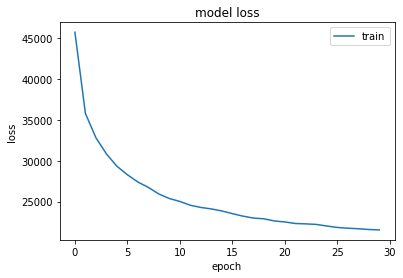

precision: 0.740506329113924, recall: 0.31451612903225806, f1: 0.44150943396226416


In [9]:
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras import regularizers
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time

class Input_data:
    def __init__(self, train_data, train_labels, eval_data, eval_labels, max_input_length):
        self.train_data = train_data
        self.train_labels = train_labels
        self.eval_data = eval_data
        self.eval_labels = eval_labels
        self.max_input_length = max_input_length
        
        
def get_all_data(data_path, smell):
    print("reading data...")
    max_eval_samples = 150000

    train_data, eval_data, eval_labels, max_input_length = \
        get_data_autoencoder(data_path,
                                    train_validate_ratio=0.7,
                                    max_training_samples=5000,
                                    max_eval_samples=max_eval_samples,
                                    )

    print("train_data: " + str(len(train_data)))
    print("train_data shape: " + str(train_data.shape))
    print("eval_data: " + str(len(eval_data)))
    print("eval_labels: " + str(len(eval_labels)))
    print("reading data... done.")
    return Input_data(train_data, None, eval_data, eval_labels, max_input_length)


def get_data_autoencoder(data_path, train_validate_ratio=0.7, max_training_samples=5000, max_eval_samples=150000):
    max_input_length = get_outlier_threshold(data_path, z=1)

    all_inputs = []
    # Positive cases
    folder_path = os.path.join(data_path, "Positive")
    pos_data_arr = _retrieve_data(folder_path, max_input_length)
    shuffle(pos_data_arr)
    total_positive_cases = len(pos_data_arr)

    # total_training_positive_cases = int(train_validate_ratio * total_positive_cases)
    total_eval_positive_cases = total_positive_cases

    # Negative cases
    folder_path = os.path.join(data_path, "Negative")
    neg_data_arr = _retrieve_data(folder_path, max_input_length)
    shuffle(neg_data_arr)
    total_negative_cases = len(neg_data_arr)

    total_training_negative_cases = int(train_validate_ratio * total_negative_cases)
    total_eval_negative_cases = int(total_negative_cases - total_training_negative_cases)

    # We balance training samples and apply max threshold for training sample count
    total_training_negative_cases = min(max_training_samples, total_training_negative_cases)

    training_data = []
    # training_data.extend(pos_data_arr[0:total_training_positive_cases])
    training_data.extend(neg_data_arr[0:total_training_negative_cases])
    training_data_arr = np.array(training_data, dtype=np.float32)

    # we need to remove extraneous samples from evaluation to keep the compuation in reasonable bounds
    if total_eval_negative_cases > max_eval_samples:
        removed_sample_percent = (total_eval_negative_cases - max_eval_samples)/total_eval_negative_cases
        total_eval_positive_cases = int(total_eval_positive_cases - total_eval_positive_cases * removed_sample_percent)
        total_eval_negative_cases = max_eval_samples

    eval_data = []
    eval_data.extend(pos_data_arr[len(pos_data_arr) - total_eval_positive_cases:])
    eval_data.extend(neg_data_arr[len(neg_data_arr) - total_eval_negative_cases:])
    eval_data_arr = np.array(eval_data, dtype=np.float32)

    eval_labels = np.empty(shape=[len(eval_data_arr)], dtype=np.float32)
    eval_labels[0:total_eval_positive_cases] = 1.0
    eval_labels[total_eval_positive_cases:] = 0.0

    training_data = training_data_arr.reshape((len(training_data_arr), max_input_length))
    eval_data = eval_data_arr.reshape((len(eval_labels), max_input_length))
    training_data = shuffle(training_data)
    eval_data, eval_labels = shuffle(eval_data, eval_labels)

    return training_data, eval_data, eval_labels, max_input_length


# The second parameter is used to specify the threshold for outlier removal
def get_outlier_threshold(path, z=1):
    len1 = _get_outlier_threshold(os.path.join(path, "Positive"), z)
    len2 = _get_outlier_threshold(os.path.join(path, "Negative"), z)
    return len1 if len1 > len2 else len2


def _get_outlier_threshold(path, z):
    lengths = []
    for root, dirs, files in os.walk(path):
        for f in files:
            if f.startswith("."):
                continue
            filepath = os.path.join(root, f)
            with open(filepath, "r", errors='ignore') as file:
                for line in file:
                    input_str = line.replace("\t", " ")
                    np_arr = np.fromstring(input_str, dtype=np.int32, sep=" ")
                    cur_width = len(np_arr)
                    lengths.append(cur_width)
    return compute_max(lengths, z=z)


def compute_max(arr, dim="width", z=2):
    mn = np.mean(arr, axis=0)
    sd = np.std(arr, axis=0)
    final_list = [x for x in arr if (x <= mn + z * sd)]  # upper outliers removed
    rmn2 = len(arr) - len(final_list)
    print('{} array size '.format(dim) + str(len(arr)))
    print('min {} '.format(dim) + str(min(arr)))
    print('max {} '.format(dim) + str(max(arr)))
    print('mean {} '.format(dim) + str(np.nanmean(arr)))
    print('standard deviation ' + str(np.std(arr)))
    print('median {} '.format(dim) + str(np.nanmedian(arr)))
    print('number of upper outliers removed ' + str(rmn2))
    print('max {} excluding upper outliers '.format(dim) + str(max(final_list)))
    return max(final_list)


def _retrieve_data(path, max_len):
    input = []
    for file in os.listdir(path):
        with open(os.path.join(path, file), 'r',
                  errors='ignore') as file_read:
            for line in file_read:
                input_str = line.replace("\t", " ")
                arr = np.fromstring(input_str, dtype=np.int32, sep=" ", count=max_len)
                arr_size = len(np.fromstring(input_str, dtype=np.int32, sep=" "))
                # We add this file only if the width is less than the outlier threshold
                if arr_size <= max_len:
                    arr[arr_size:max_len] = 0
                    input.append(arr)
    return input


def write_result(file, str):
    f = open(file, "a+")
    f.write(str)
    f.close()
    
    
def get_out_file(smell):
    now = datetime.datetime.now()
    if not os.path.exists(OUT_FOLDER):
        os.makedirs(OUT_FOLDER)
    return os.path.join(OUT_FOLDER, "ae_" + smell + "_"
                        + str(now.strftime("%d%m%Y_%H%M") + ".csv"))




def autoencoder_dense(data, smell, no_of_layers=1, encoding_dimension=32, epochs=10, with_bottleneck=True, threshold=400000):
    input_layer = Input(shape=(data.max_input_length,))
    prev_layer = input_layer
    for i in range(no_of_layers):
        encoder = Dense(int(encoding_dimension / pow(2, i)), activation="relu",
                        activity_regularizer=regularizers.l1(10e-3))(prev_layer)
        prev_layer = encoder
    # bottleneck
    if with_bottleneck:
        prev_layer = Dense(int(encoding_dimension / pow(2, no_of_layers)), activation="relu")(prev_layer)
    for j in range(no_of_layers - 1, -1, -1):
        decoder = Dense(int(encoding_dimension / pow(2, j)), activation='relu')(prev_layer)
        prev_layer = decoder
    prev_layer = Dense(data.max_input_length, activation='relu')(prev_layer)
    autoencoder = Model(inputs=input_layer, outputs=prev_layer)

    autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['accuracy'])
    autoencoder.summary()

    history = autoencoder.fit(data.train_data,
                              data.train_data,
                              epochs=epochs,
                              batch_size=32,
                              verbose=1,
                              shuffle=True).history

    plt.plot(history['loss'])
#     plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    predictions = autoencoder.predict(data.eval_data)
    mse = np.mean(np.power(data.eval_data - predictions, 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse,
                             'True_class': data.eval_labels})
    return find_metrics(error_df, threshold)


def find_metrics(error_df, threshold):
    y_pred = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, y_pred)
    precision, recall, f1 = compute_metrics(conf_matrix)
    return threshold, precision, recall, f1


def compute_metrics(conf_matrix):
    precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
    recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])
    f1 = (2 * precision * recall) / (precision + recall)
    print("precision: " + str(precision) + ", recall: " + str(recall) + ", f1: " + str(f1))
    return precision, recall, f1


def autoencoder(smell, input_data, layer, epochs=20, encoding=1024, bottleneck=True, threshold=400000):
    outfile = get_out_file(smell)
    write_result(outfile,
                 "Encoding_dim,threshold,epoch,bottleneck,layer,precision,recall,f1,time\n")
    start_time = time.time()
    try:
        optimal_threshold, max_pr, max_re, max_f1 = autoencoder_dense(input_data, smell, no_of_layers=layer,
                                                                      epochs=epochs,
                                                                      encoding_dimension=encoding,
                                                                      with_bottleneck=bottleneck,
                                                                      threshold=threshold)
    except ValueError as error:
        print(error)
    end_time = time.time()
    time_taken = end_time - start_time
    write_result(outfile,
                 str(encoding) + "," + str(optimal_threshold) + "," + str(
                     epochs) + "," + str(bottleneck) + "," + str(layer) + "," +
                 str(max_pr) + "," + str(max_re) + "," + str(max_f1) + "," + str(time_taken) + "\n")
    

data_path = os.path.join(os.path.join(TOKENIZER_OUT_FOLDER, 'ComplexMethod'), '1d')
input_data = get_all_data(data_path, 'ComplexMethod')
autoencoder('ComplexMethod', input_data=input_data, layer=1,
                                epochs=30, encoding=32, bottleneck=True, threshold=319000)